# <center>Neural Networks from Scratch</center>
<center> Shan-Hung Wu & DataLab </center>
<center> Fall 2022 </center>

In this tutorial, you will learn the fundamentals of how you can build neural networks without the help of the deep learning frameworks, and instead by using NumPy.
<img src="./figs/deep_nn-1.png" width="800" style="display: block; margin-left: auto; margin-right: auto;"/>

Creating complex neural networks with different architectures in Python should be a standard practice for any Machine Learning Engineer and Data Scientist. But a genuine understanding of how a neural network works is equally as valuable. This is what we aim to expand on in this article, the very fundamentals on how we can build neural networks, without the help of the frameworks that make it easy for us.

## Model architecture
We are building a basic deep neural network with 3 layers in total: 1 input layer, 1 hidden layers and 1 output layer. All layers will be fully connected. We implement ReLU and sigmoid activation functions. SGD and Momentum optimizer are available.

Let's try to define the layers in an exact way. To be able to classify digits, we must end up with the probabilities of an image belonging to a certain class, after running the neural network, because then we can quantify how well our neural network performed.

1. Input layer: In this layer, we input our dataset, consisting of 28x28 images. We flatten these images into one array with $28×28=784$ elements. This means our input layer will have 784 nodes.
2. Hidden layer: In this layer, we have decided to reduce the number of nodes from 784 in the input layer to 64 nodes.
3. Output layer: In this layer, we are reducing the 64 nodes to a total of 10 nodes, so that we can evaluate the nodes against the label. This label is received in the form of an array with 10 elements, where one of the elements is 1, while the rest is 0.

In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import time

## Helper functions

In [2]:
# Helper function
def show_images(image, num_row=2, num_col=5):
    # plot images
    image_size = int(np.sqrt(image.shape[-1]))
    image = np.reshape(image, (image.shape[0], image_size, image_size))
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(num_row*num_col):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(image[i], cmap='gray', vmin=0, vmax=1)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
def one_hot(x, k, dtype=np.float32):
    """Create a one-hot encoding of x of size k."""
    return np.array(x[:, None] == np.arange(k), dtype)

## Dataset preparation
In this tutorial, we will use [MNIST dataset](http://yann.lecun.com/exdb/mnist/) to demo how to build a neural network. MNIST contains 70,000 images of hand-written digits, 60,000 for training while 10,000 for testing, each $28×28$ pixels, in greyscale with pixel-values from 0 to 255.

You might notice we not only import Numpy, but also Scikit-learn and Matplotlib. Matplotlib helps us visualize the training data, while Scikit-learn let us load the dataset more easily, but they are not used for any of the actual neural network. There are many ways to load dataset, you can choose any one you prefer.


### Note
To load dataset, `fetch_openml` requires `scikit-learn >= 0.22`. For older version, please change `from sklearn.datasets import fetch_openml` to `from sklearn.datasets import fetch_mldata`.

Now we have to load the dataset and preprocess it, so that we can use it in NumPy. We do normalization by dividing all images by 255, and make it such that all images have values between 0 and 1, since this removes some of the numerical stability issues with activation functions later on. We choose to go with one-hot encoded labels, since we can more easily subtract these labels from the output of the neural network. We also choose to load our inputs as flattened arrays of 28 * 28 = 784 elements, since that is what the input layer requires.

In [3]:
# Load data
mnist_data = fetch_openml("mnist_784")
x = np.array(mnist_data["data"])
y = np.array(mnist_data["target"])

# Normalize
x /= 255.0

# One-hot encode labels
num_labels = 10
examples = y.shape[0]
y_new = one_hot(y.astype('int32'), num_labels)

# Split, reshape, shuffle
train_size = 60000
test_size = x.shape[0] - train_size
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y_new[:train_size], y_new[train_size:]
shuffle_index = np.random.permutation(train_size)
x_train, y_train = x_train[shuffle_index], y_train[shuffle_index]

Training data: (60000, 784) (60000, 10)
Test data: (10000, 784) (10000, 10)


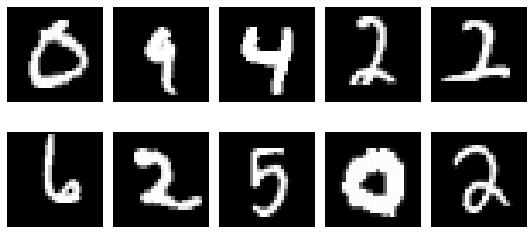

In [4]:
print("Training data: {} {}".format(x_train.shape, y_train.shape))
print("Test data: {} {}".format(x_test.shape, y_test.shape))
show_images(x_train)

## Initialization
The specific problem that arises, when trying to implement the feedforward neural network, is that we are trying to transform from 784 nodes all the way down to 10 nodes. When instantiating the `DeepNeuralNetwork` class, we pass in an array of sizes that defines the number of activations for each layer.

```python
dnn = DeepNeuralNetwork(sizes=[784, 64, 10])
```

This initializes the `DeepNeuralNetwork` class by the init function.

```python
def __init__(self, sizes, activation='sigmoid'):
    self.sizes = sizes

    # Choose activation function
    if activation == 'relu':
        self.activation = self.relu
    elif activation == 'sigmoid':
        self.activation = self.sigmoid

    # Save all weights
    self.params = self.initialize()
    # Save all intermediate values, i.e. activations
    self.cache = {}
```

To smarten up our initialization, we shrink the variance of the weights in each layer. Following [this nice video](https://www.coursera.org/lecture/deep-neural-network/weight-initialization-for-deep-networks-RwqYe) by Andrew Ng, we’ll set the variance for each layer to 1/n, where n is the number of inputs feeding into that layer. We use `np.random.randn()` function to get our initial weights, which draws from the standard normal distribution. So to adjust the variance to 1/n, we just divide by √n. 

The initialization of weights in the neural network is kind of hard to think about. To really understand how and why the following approach works, you need a grasp of linear algebra, specifically dimensionality when using the dot product operation, which is beyond the scope of this class.

```python
def initialize(self):
    # number of nodes in each layer
    input_layer=self.sizes[0]
    hidden_layer=self.sizes[1]
    output_layer=self.sizes[2]

    params = {
        "W1": np.random.randn(hidden_layer, input_layer) * np.sqrt(1./input_layer),
        "b1": np.zeros((hidden_layer, 1)),
        "W2": np.random.randn(output_layer, hidden_layer) * np.sqrt(1./hidden_layer),
        "b2": np.zeros((output_layer, 1))
    }
    return params
```

## Feedforward
The forward pass consists of the dot operation in NumPy, which turns out to be just matrix multiplication. As described in the [introduction to neural networks](https://mlfromscratch.com/neural-networks-explained/#/) article, we have to multiply the weights by the activations of the previous layer. Then we have to apply the activation function to the outcome. 

To get through each layer, we sequentially apply the dot operation, followed by the sigmoid/relu activation function. In the last layer we use the softmax activation function, since we wish to have probabilities of each class, so that we can measure how well our current forward pass performs.

<img src="./figs/backprop_algo_forward.png" width="300"/>

```python
def feed_forward(self, x):
    self.cache["X"] = x
    self.cache["Z1"] = np.matmul(self.params["W1"], self.cache["X"].T) +\
                                                        self.params["b1"]
    self.cache["A1"] = self.activation(self.cache["Z1"])
    self.cache["Z2"] = np.matmul(self.params["W2"], self.cache["A1"]) +\
                                                        self.params["b2"]
    self.cache["A2"] = self.softmax(self.cache["Z2"])
    return self.cache["A2"]
```

The following are the activation functions used for this article. As you can see, we provide a derivative version of the relu and sigmoid, since we will need that later on when backpropagating through the neural network.

```python
def relu(self, x, derivative=False):
    if derivative:
        x = np.where(x < 0, 0, x)
        x = np.where(x >= 0, 1, x)
        return x
    return np.maximum(0, x)

def sigmoid(self, x, derivative=False):
    if derivative:
        return (np.exp(-x))/((np.exp(-x)+1)**2)
    return 1/(1 + np.exp(-x))

def softmax(self, x):
    # Numerically stable with large exponentials
    exps = np.exp(x - x.max())
    return exps / np.sum(exps, axis=0)
```

Note: A numerical stable version of the softmax function was chosen, you can read more from [Stanford CS231n](https://cs231n.github.io/linear-classify/#softmax) course.

## Backpropagation
The backward pass is hard to get right, because there are so many sizes and operations that have to align, for all the operations to be successful. Here is the full function for the backward pass; we will go through each weight update below.

<img src="./figs/backprop_algo_backward.png" width="400"/>

For people who are interested in the magic of backpropagation, please refer to [this nice article](https://mlfromscratch.com/neural-networks-explained/). For people who want to deep dive into methmetics and understand thoroughly, please refer to [NTHU CS565600 Deep Learning](https://nthu-datalab.github.io/ml/index.html). Here is [slide](https://nthu-datalab.github.io/ml/slides/10_NN_Design.pdf) and [video](https://www.youtube.com/watch?v=uYRUbvyKXAo&list=PLlPcwHqLqJDk3A0qFgFUDlyALzaF44NTL&index=4&ab_channel=Shan-HungWu) for backpropagation.

```python
def back_propagate(self, y, output):
    current_batch_size = y.shape[0]

    dZ2 = output - y.T
    dW2 = (1./current_batch_size) * np.matmul(dZ2, self.cache["A1"].T)
    db2 = (1./current_batch_size) * np.sum(dZ2, axis=1, keepdims=True)

    dA1 = np.matmul(self.params["W2"].T, dZ2)
    dZ1 = dA1 * self.activation(self.cache["Z1"], derivative=True)
    dW1 = (1./current_batch_size) * np.matmul(dZ1, self.cache["X"])
    db1 = (1./current_batch_size) * np.sum(dZ1, axis=1, keepdims=True)

    self.grads = {"W1": dW1, "b1": db1, "W2": dW2, "b2": db2}
    return self.grads
```

## Training (Stochastic Gradient Descent)
We have defined a forward and backward pass, but how can we start using them? We have to make a training loop and choose to use Stochastic Gradient Descent (SGD) as the optimizer to update the parameters of the neural network.

There are two main loops in the training function. One loop for the number of epochs, which is the number of times we run through the whole dataset, and a second loop for running through each batch one by one.

For each batch, we do a forward pass by calling `self.feedforward()` with `x`, which is one batch in an array with the length 784, as explained earlier. The `output` of the forward pass is used along with `y`, which are the one-hot encoded labels (the ground truth), in the backward pass. `self.back_propagate()` returns the gradients of weights.

```python
def train(self, x_train, y_train, x_test, y_test):
    for i in range(self.epochs):
        # Shuffle
        permutation = np.random.permutation(x_train.shape[0])
        x_train_shuffled = x_train[permutation]
        y_train_shuffled = y_train[permutation]

        for j in range(num_batches):
            # Batch
            begin = j * self.batch_size
            end = min(begin + self.batch_size, x_train.shape[0]-1)
            x = x_train_shuffled[begin:end]
            y = y_train_shuffled[begin:end]

            # Forward
            output = self.feed_forward(x)
            # Backprop
            grad = self.back_propagate(y, output)
            # Optimize
            self.optimize(l_rate=l_rate, beta=beta)
```

The `optimize()` function has the code for both SGD and momentum update rules. SGD algorithm is relatively straightforward, updating the networks by calculated gradient directly, while momentum make the same movement in the last iteration, corrected by negative gradient.

```python
def optimize(self, l_rate=0.1, beta=.9):
    '''
        Stochatic Gradient Descent (SGD):
        θ^(t+1) <- θ^t - η∇L(y, ŷ)

        Momentum:
        v^(t+1) <- βv^t + (1-β)∇L(y, ŷ)^t
        θ^(t+1) <- θ^t - ηv^(t+1)
    '''
    if self.optimizer == "sgd":
        for key in self.params:
            self.params[key] = self.params[key] -\
                                        l_rate*self.grads[key]
    elif self.optimizer == "momentum":
        for key in self.params:
            self.momemtum_opt[key] = (beta*self.momemtum_opt[key] +\
                                      (1.-beta)*self.grads[key])
            self.params[key] = self.params[key] -\
                                        l_rate * self.momemtum_opt[key]

```

After having updated the parameters of the neural network, we can measure the accuracy on a validation set that we conveniently prepared earlier, to validate how well our network performs after each iteration over the whole dataset.

```python
def accuracy(self, y, output):
    return np.mean(np.argmax(y, axis=-1) == np.argmax(output.T, axis=-1))
```

Finally, we can call the training function, after knowing what will happen. We use the training and validation data as input to the training function, and then we wait.

```python
dnn.train(x_train, y_train, x_val, y_val)
```

## 3-layer neural network with Numpy
Here is the full code, for an easy copy-paste and overview of what's happening.

In [5]:
class DeepNeuralNetwork():
    def __init__(self, sizes, activation='sigmoid'):
        self.sizes = sizes
        
        # Choose activation function
        if activation == 'relu':
            self.activation = self.relu
        elif activation == 'sigmoid':
            self.activation = self.sigmoid
        else:
            raise ValueError("Activation function is currently not support, please use 'relu' or 'sigmoid' instead.")
        
        # Save all weights
        self.params = self.initialize()
        # Save all intermediate values, i.e. activations
        self.cache = {}
        
    def relu(self, x, derivative=False):
        '''
            Derivative of ReLU is a bit more complicated since it is not differentiable at x = 0
        
            Forward path:
            relu(x) = max(0, x)
            In other word,
            relu(x) = 0, if x < 0
                    = x, if x >= 0

            Backward path:
            ∇relu(x) = 0, if x < 0
                     = 1, if x >=0
        '''
        if derivative:
            x = np.where(x < 0, 0, x)
            x = np.where(x >= 0, 1, x)
            return x
        return np.maximum(0, x)

    def sigmoid(self, x, derivative=False):
        '''
            Forward path:
            σ(x) = 1 / 1+exp(-z)
            
            Backward path:
            ∇σ(x) = exp(-z) / (1+exp(-z))^2
        '''
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))

    def softmax(self, x):
        '''
            softmax(x) = exp(x) / ∑exp(x)
        '''
        # Numerically stable with large exponentials
        exps = np.exp(x - x.max())
        return exps / np.sum(exps, axis=0)

    def initialize(self):
        # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_layer=self.sizes[1]
        output_layer=self.sizes[2]
        
        params = {
            "W1": np.random.randn(hidden_layer, input_layer) * np.sqrt(1./input_layer),
            "b1": np.zeros((hidden_layer, 1)),
            "W2": np.random.randn(output_layer, hidden_layer) * np.sqrt(1./hidden_layer),
            "b2": np.zeros((output_layer, 1))
        }
        return params
    
    def initialize_momemtum_optimizer(self):
        momemtum_opt = {
            "W1": np.zeros(self.params["W1"].shape),
            "b1": np.zeros(self.params["b1"].shape),
            "W2": np.zeros(self.params["W2"].shape),
            "b2": np.zeros(self.params["b2"].shape),
        }
        return momemtum_opt

    def feed_forward(self, x):
        '''
            y = σ(wX + b)
        '''
        self.cache["X"] = x
        self.cache["Z1"] = np.matmul(self.params["W1"], self.cache["X"].T) + self.params["b1"]
        self.cache["A1"] = self.activation(self.cache["Z1"])
        self.cache["Z2"] = np.matmul(self.params["W2"], self.cache["A1"]) + self.params["b2"]
        self.cache["A2"] = self.softmax(self.cache["Z2"])
        return self.cache["A2"]
    
    def back_propagate(self, y, output):
        '''
            This is the backpropagation algorithm, for calculating the updates
            of the neural network's parameters.

            Note: There is a stability issue that causes warnings. This is 
                  caused  by the dot and multiply operations on the huge arrays.
                  
                  RuntimeWarning: invalid value encountered in true_divide
                  RuntimeWarning: overflow encountered in exp
                  RuntimeWarning: overflow encountered in square
        '''
        current_batch_size = y.shape[0]
        
        dZ2 = output - y.T
        dW2 = (1./current_batch_size) * np.matmul(dZ2, self.cache["A1"].T)
        db2 = (1./current_batch_size) * np.sum(dZ2, axis=1, keepdims=True)

        dA1 = np.matmul(self.params["W2"].T, dZ2)
        dZ1 = dA1 * self.activation(self.cache["Z1"], derivative=True)
        dW1 = (1./current_batch_size) * np.matmul(dZ1, self.cache["X"])
        db1 = (1./current_batch_size) * np.sum(dZ1, axis=1, keepdims=True)

        self.grads = {"W1": dW1, "b1": db1, "W2": dW2, "b2": db2}
        return self.grads
    
    def cross_entropy_loss(self, y, output):
        '''
            L(y, ŷ) = −∑ylog(ŷ).
        '''
        l_sum = np.sum(np.multiply(y.T, np.log(output)))
        m = y.shape[0]
        l = -(1./m) * l_sum
        return l
                
    def optimize(self, l_rate=0.1, beta=.9):
        '''
            Stochatic Gradient Descent (SGD):
            θ^(t+1) <- θ^t - η∇L(y, ŷ)
            
            Momentum:
            v^(t+1) <- βv^t + (1-β)∇L(y, ŷ)^t
            θ^(t+1) <- θ^t - ηv^(t+1)
        '''
        if self.optimizer == "sgd":
            for key in self.params:
                self.params[key] = self.params[key] - l_rate * self.grads[key]
        elif self.optimizer == "momentum":
            for key in self.params:
                self.momemtum_opt[key] = (beta * self.momemtum_opt[key] + (1. - beta) * self.grads[key])
                self.params[key] = self.params[key] - l_rate * self.momemtum_opt[key]
        else:
            raise ValueError("Optimizer is currently not support, please use 'sgd' or 'momentum' instead.")

    def accuracy(self, y, output):
        return np.mean(np.argmax(y, axis=-1) == np.argmax(output.T, axis=-1))

    def train(self, x_train, y_train, x_test, y_test, epochs=10, 
              batch_size=64, optimizer='momentum', l_rate=0.1, beta=.9):
        # Hyperparameters
        self.epochs = epochs
        self.batch_size = batch_size
        num_batches = -(-x_train.shape[0] // self.batch_size)
        
        # Initialize optimizer
        self.optimizer = optimizer
        if self.optimizer == 'momentum':
            self.momemtum_opt = self.initialize_momemtum_optimizer()
        
        start_time = time.time()
        template = "Epoch {}: {:.2f}s, train acc={:.2f}, train loss={:.2f}, test acc={:.2f}, test loss={:.2f}"
        
        # Train
        for i in range(self.epochs):
            # Shuffle
            permutation = np.random.permutation(x_train.shape[0])
            x_train_shuffled = x_train[permutation]
            y_train_shuffled = y_train[permutation]

            for j in range(num_batches):
                # Batch
                begin = j * self.batch_size
                end = min(begin + self.batch_size, x_train.shape[0]-1)
                x = x_train_shuffled[begin:end]
                y = y_train_shuffled[begin:end]
                
                # Forward
                output = self.feed_forward(x)
                # Backprop
                grad = self.back_propagate(y, output)
                # Optimize
                self.optimize(l_rate=l_rate, beta=beta)

            # Evaluate performance
            # Training data
            output = self.feed_forward(x_train)
            train_acc = self.accuracy(y_train, output)
            train_loss = self.cross_entropy_loss(y_train, output)
            # Test data
            output = self.feed_forward(x_test)
            test_acc = self.accuracy(y_test, output)
            test_loss = self.cross_entropy_loss(y_test, output)
            print(template.format(i+1, time.time()-start_time, train_acc, train_loss, test_acc, test_loss))

## Results
The results completely dependent on how the weights are initialized and the activation function we use. Experimentally, due to non-bounded behavior of `relu()`, the learning rate should be set much smaller than the one for `sigmoid()` (bounded). In addition, training with SGD optimizer with momentum should have better result since it avoids from getting stuck in local minima or saddle points.

The reason behind this phenomenon is complicated and beyond the scope of this class. In short, the training results will be more stable and consistent as the batch size increases.

In [6]:
# Sigmoid + Momentum
dnn = DeepNeuralNetwork(sizes=[784, 64, 10], activation='sigmoid')
dnn.train(x_train, y_train, x_test, y_test, batch_size=128, optimizer='momentum', l_rate=4, beta=.9)

Epoch 1: 0.70s, train acc=0.95, train loss=0.16, test acc=0.95, test loss=0.17
Epoch 2: 1.45s, train acc=0.97, train loss=0.11, test acc=0.96, test loss=0.13
Epoch 3: 2.19s, train acc=0.98, train loss=0.08, test acc=0.97, test loss=0.10
Epoch 4: 2.92s, train acc=0.98, train loss=0.06, test acc=0.97, test loss=0.10
Epoch 5: 3.64s, train acc=0.98, train loss=0.05, test acc=0.97, test loss=0.09
Epoch 6: 4.47s, train acc=0.99, train loss=0.04, test acc=0.97, test loss=0.09
Epoch 7: 5.21s, train acc=0.99, train loss=0.04, test acc=0.97, test loss=0.09
Epoch 8: 5.99s, train acc=0.99, train loss=0.03, test acc=0.97, test loss=0.09
Epoch 9: 6.76s, train acc=0.99, train loss=0.03, test acc=0.97, test loss=0.09
Epoch 10: 7.49s, train acc=0.99, train loss=0.03, test acc=0.97, test loss=0.09


In [7]:
# ReLU + SGD
dnn = DeepNeuralNetwork(sizes=[784, 64, 10], activation='relu')
dnn.train(x_train, y_train, x_test, y_test, batch_size=128, optimizer='sgd', l_rate=0.05)

Epoch 1: 0.61s, train acc=0.89, train loss=0.41, test acc=0.89, test loss=0.39
Epoch 2: 1.22s, train acc=0.90, train loss=0.33, test acc=0.91, test loss=0.31
Epoch 3: 1.88s, train acc=0.91, train loss=0.30, test acc=0.92, test loss=0.29
Epoch 4: 2.47s, train acc=0.92, train loss=0.29, test acc=0.92, test loss=0.28
Epoch 5: 3.06s, train acc=0.92, train loss=0.28, test acc=0.92, test loss=0.27
Epoch 6: 3.66s, train acc=0.92, train loss=0.27, test acc=0.92, test loss=0.26
Epoch 7: 4.26s, train acc=0.92, train loss=0.26, test acc=0.93, test loss=0.26
Epoch 8: 4.85s, train acc=0.93, train loss=0.25, test acc=0.93, test loss=0.25
Epoch 9: 5.46s, train acc=0.93, train loss=0.25, test acc=0.93, test loss=0.25
Epoch 10: 6.05s, train acc=0.93, train loss=0.25, test acc=0.93, test loss=0.25


## Good exercises in NumPy
You might have noticed that the code is very readable, but takes up a lot of space and could be optimized to run in loops. Here is a chance to optimize and improve the code. For example, you can optimize the forward and backward pass, such that they run in a for loop in each function. This makes the code easier to modify and possibly easier to maintain. 

More challenging exercises including implement any other activation function from this overview of activation functions, and remember to implement the derivatives as well. Different optimizers, e.g. Adam, RMSProp, etc, are also worth to try.

## Reference 
1. [CS565600 Deep Learning](https://nthu-datalab.github.io/ml/index.html), National Tsing Hua University
2. [Building a Neural Network from Scratch: Part 1](https://jonathanweisberg.org/post/A%20Neural%20Network%20from%20Scratch%20-%20Part%201/)
3. [Building a Neural Network from Scratch: Part 2](https://jonathanweisberg.org/post/A%20Neural%20Network%20from%20Scratch%20-%20Part%202/)
4. [Neural networks from scratch](https://developer.ibm.com/technologies/artificial-intelligence/articles/neural-networks-from-scratch), IBM Developer
5. [The Softmax Function Derivative (Part 1)](https://aimatters.wordpress.com/2019/06/17/the-softmax-function-derivative/)